In [1]:
#temperary environment setup
!pip install -r /teamspace/studios/this_studio/environment/requirements.txt

## Part 1 - Organize the Audio Data

In [2]:
import utils as u
import librosa
import soundfile as sf
import os
import numpy as np

In [3]:
%pip install soundfile

In [4]:
# no need to convert again in the future, just use the files in wav_files folder directly
data_home = '/teamspace/studios/this_studio/data/dev_set'
# u.convert_flac_to_wav_librosa(data_home)

In [5]:
wav_directory = '/teamspace/studios/this_studio/data/dev_set/wav_files'
label_file = '/teamspace/studios/this_studio/data/dev.txt'

In [6]:
#is there a way to not having to load data and labels everytime?
audio_data, audio_labels = u.load_data(wav_directory, label_file)

In [7]:
# Example of using loaded data
print("Loaded", len(audio_data), "audio files.")
print("Sample labels:", audio_labels[:10]) # Print the first 10 labels

Loaded 41728 audio files.
Sample labels: ['deepfake', 'deepfake', 'deepfake', 'deepfake', 'deepfake', 'deepfake', 'deepfake', 'deepfake', 'deepfake', 'deepfake']


Look at one sample from the dataset

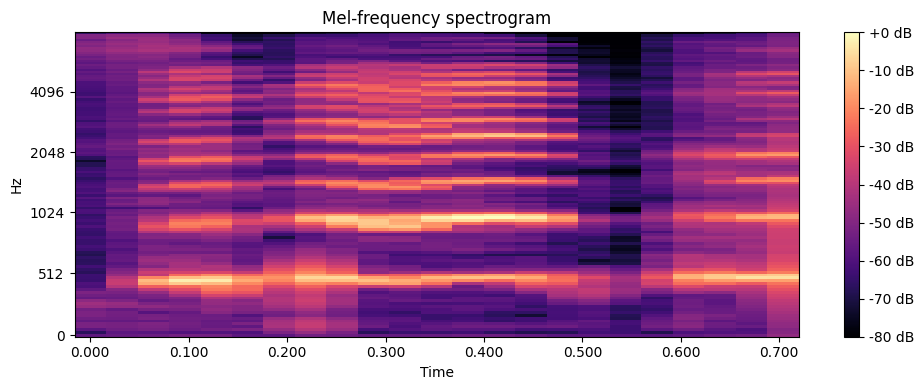

sr= 16000


In [8]:
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
import numpy as np

# Load an audio file
file_path = '/teamspace/studios/this_studio/data/dev_set/wav_files/CtrSVDD_0059_D_0000530.wav'
audio, sr = librosa.load(file_path, sr=None)  # Load with the original sample rate

# Play the audio
display(Audio(data=audio, rate=sr))

# Plot the spectrogram. refer: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html
plt.figure(figsize=(10, 4))
S = librosa.feature.melspectrogram(y=audio, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

print("sr=", sr)

Define Splite

In [9]:
train_data, val_data, test_data, train_labels, val_labels, test_labels = u.split_data(
    audio_data, audio_labels, test_size=0.2, val_size=0.2)

print("Training data size:", len(train_data))
print("Validation data size:", len(val_data))
print("Test data size:", len(test_data))

Training data size: 25036
Validation data size: 8346
Test data size: 8346


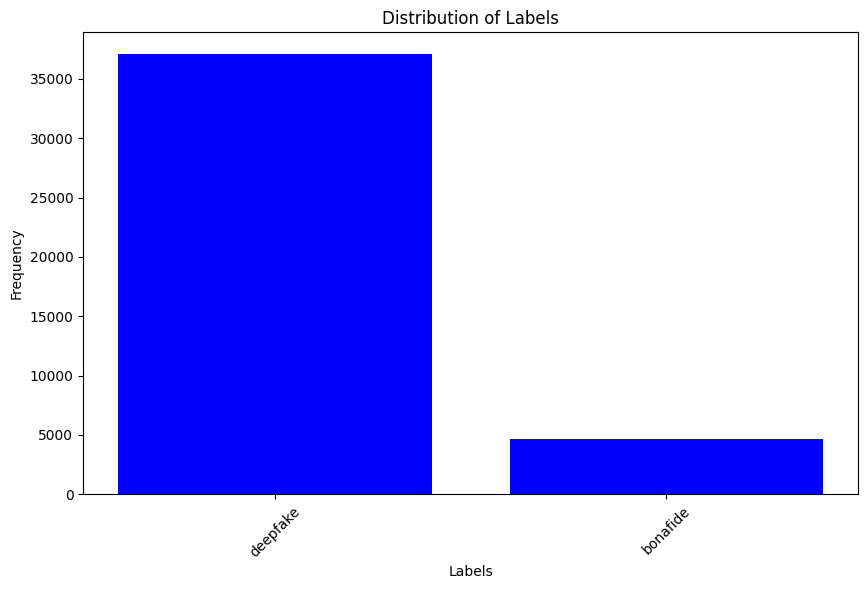

In [10]:
u.plot_label_distribution(audio_labels)

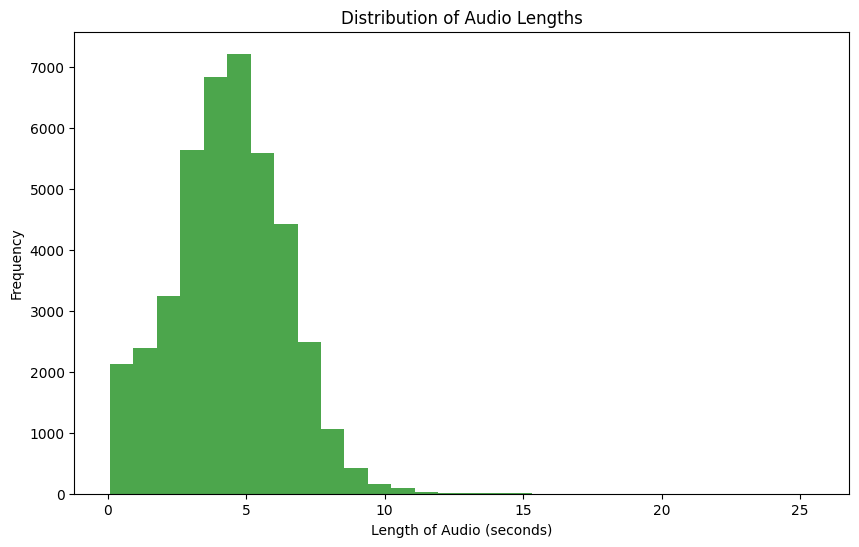

In [11]:
u.plot_audio_length_distribution(audio_data, sr)

### Data Preprocessing

MFCC & LFCC 

In [12]:
#look at the lfcc of one audio file
audio, sr = librosa.load('/teamspace/studios/this_studio/data/dev_set/wav_files/CtrSVDD_0059_D_0000530.wav', sr=None)  # Load an audio file
mfccs = u.compute_mfcc(audio, sr)
print("MFCCs:", mfccs.shape)

MFCCs: (13, 23)


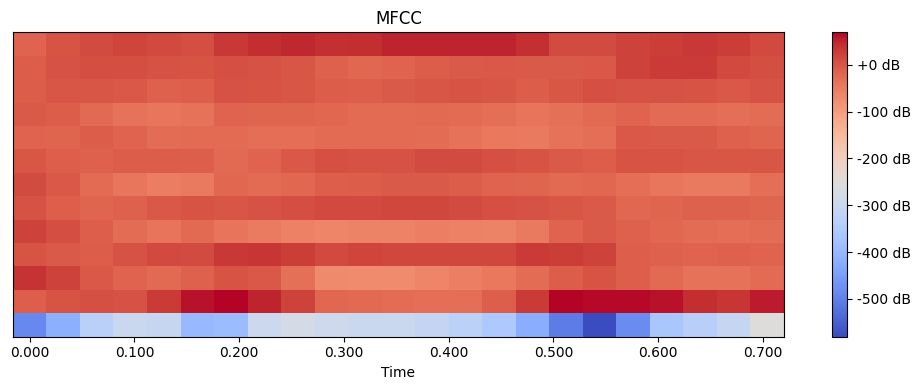

In [13]:
u.plot_mfcc(mfccs, sr)

In [14]:
lfccs = u.compute_lfcc(audio, sr)
print("LFCCs:", lfccs.shape)

LFCCs: (13, 23)


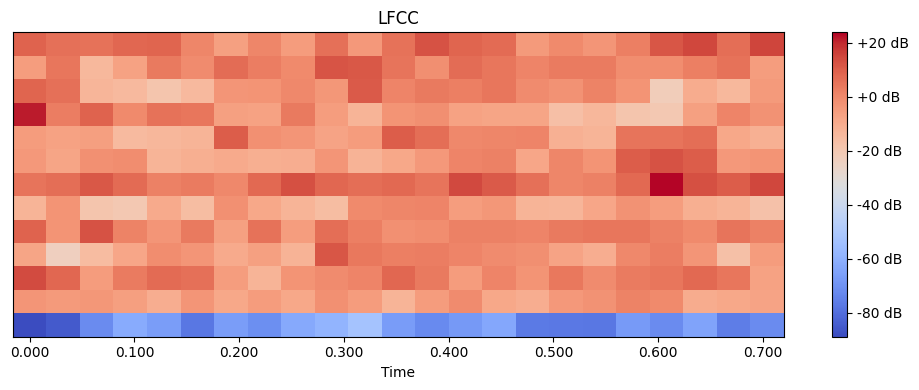

In [15]:
u.plot_lfcc(lfccs, sr)

Prepare Data for Modeling

In [16]:
# Batch Processing for Feature Extraction
# Test 
test_file_paths = ['/teamspace/studios/this_studio/data/dev_set/wav_files/CtrSVDD_0059_D_0000525.wav',
                   '/teamspace/studios/this_studio/data/dev_set/wav_files/CtrSVDD_0059_D_0000526.wav']  # Add your actual paths
test_features, test_sr = u.load_and_extract_features(test_file_paths, feature_type='lfcc')

print("Shape of extracted features:", test_features.shape)
print("Sample rate used:", test_sr)

Shape of extracted features: (26, 54)
Sample rate used: 16000


In [17]:
#test storing features in h5 file
import h5py

# Create an HDF5 file
with h5py.File('/teamspace/studios/this_studio/data/test_LFCC_features.h5', 'w') as h5f:
    # Create a dataset in the file
    h5f.create_dataset('LFCC_dataset_test', data=np.array(test_features))

In [18]:
test_features, test_sr = u.load_and_extract_features(test_file_paths, feature_type='mfcc')

print("Shape of extracted features:", test_features.shape)
print("Sample rate used:", test_sr)

Shape of extracted features: (26, 54)
Sample rate used: 16000


In [19]:
# from concurrent.futures import ProcessPoolExecutor

def process_file(file_path):
    features, _ = u.load_and_extract_features([file_path], feature_type='lfcc')
    return features

In [20]:
dataset_directory = '/teamspace/studios/this_studio/data/wav_files'

#refer to ChatGPT
audio_files = [os.path.join(dataset_directory, f) for f in os.listdir(dataset_directory) if f.endswith('.wav') and os.path.isfile(os.path.join(dataset_directory, f))]

# with ProcessPoolExecutor() as executor:
#     all_features = list(executor.map(process_file, audio_files))

# alternative if not using parallel processing

all_features = []
for file_path in audio_files:
    feature = process_file(file_path)
    if feature is not None:
        all_features.append(feature)

# print("Features extracted. Number of files processed:", len(all_features))

# Optionally filter out None values and check shapes
valid_features = []
shapes = set()
for feature in all_features:
    valid_features.append(feature)
    shapes.add(feature.shape)

print("Unique feature shapes:", shapes)

Unique feature shapes: {(13, 88), (13, 97), (13, 335), (13, 106), (13, 362), (13, 200), (13, 209), (13, 218), (13, 227), (13, 236), (13, 474), (13, 65), (13, 74), (13, 83), (13, 321), (13, 92), (13, 330), (13, 101), (13, 339), (13, 348), (13, 186), (13, 195), (13, 204), (13, 213), (13, 222), (13, 51), (13, 60), (13, 69), (13, 78), (13, 316), (13, 87), (13, 325), (13, 334), (13, 352), (13, 590), (13, 181), (13, 190), (13, 199), (13, 208), (13, 446), (13, 217), (13, 46), (13, 55), (13, 64), (13, 302), (13, 73), (13, 311), (13, 82), (13, 320), (13, 329), (13, 338), (13, 167), (13, 176), (13, 185), (13, 194), (13, 432), (13, 203), (13, 32), (13, 41), (13, 50), (13, 59), (13, 297), (13, 68), (13, 306), (13, 315), (13, 324), (13, 333), (13, 162), (13, 171), (13, 180), (13, 189), (13, 198), (13, 27), (13, 454), (13, 36), (13, 45), (13, 283), (13, 54), (13, 292), (13, 63), (13, 301), (13, 310), (13, 319), (13, 148), (13, 157), (13, 166), (13, 175), (13, 184), (13, 13), (13, 22), (13, 449), (13

In [21]:
#where kernel often crashes
# Determine the maximum length from the shapes printed
max_length = 0
for shape in shapes:
    length = shape[1]
    if length > max_length:

        max_length = length\

# Pad all features to the maximum length
uniform_features = u.pad_features(all_features, max_length)

# Convert list of arrays into a single numpy array for storage
uniform_features_array = np.array(uniform_features)

In [24]:
# Create an HDF5 file
with h5py.File('/teamspace/studios/this_studio/data/LFCC_features.h5', 'w') as h5f:
    # Create a dataset in the file
    h5f.create_dataset('LFCC_dataset_1', data=np.array(uniform_features_array))
